In [8]:
import numpy as np
from seemps.analysis.interpolation import *
from seemps.analysis.space import Space
from seemps.analysis.finite_differences import *
from seemps.state import MPS
from seemps.state.core import DEFAULT_STRATEGY
from tests.tools import *
from tests.tools_interpolation import *


class TestInterpolation(TestCase):
    strategy = DEFAULT_STRATEGY.replace(simplify=2)

    def test_fourier_interpolation_1D(self):
        for n in range(3, 8):
            qubits_per_dimension = [n]
            dims = [2**n for n in qubits_per_dimension]
            L = 10
            space = Space(qubits_per_dimension, L=[[-L / 2, L / 2]])
            r_N = get_position_regular_grid(dims, space.a, space.dx)
            sol_N = gaussian(r_N)
            sol_N_mps = MPS.from_vector(
                sol_N, [2] * sum(qubits_per_dimension), normalize=False
            )
            m = n + 2
            M = 2**m
            sol_int = fourier_interpolation_vector_1D(sol_N, M)
            sol_int /= np.linalg.norm(sol_int)
            sol_int_mps, _ = fourier_interpolation_1D(
                sol_N_mps, space, n, m, dim=0, strategy=self.strategy
            )
            self.assertSimilar(sol_int, sol_int_mps)

    def test_fourier_interpolation(self):
        for n in range(3, 8):
            qubits_per_dimension = [n, n]
            dims = [2**n for n in qubits_per_dimension]
            L = 10
            space = Space(qubits_per_dimension, L=[[-L / 2, L / 2], [-L / 2, L / 2]])
            r_N = get_position_regular_grid(dims, space.a, space.dx)
            sol_N = gaussian(r_N)
            sol_N_mps = MPS.from_vector(
                sol_N, [2] * sum(qubits_per_dimension), normalize=False
            )
            m = n + 2
            qubits_per_dimension_M = [m, m]
            dims_M = [2**m for m in qubits_per_dimension_M]
            sol_int = fourier_interpolation_vector(sol_N, dims_M)
            sol_int /= np.linalg.norm(sol_int)
            sol_int_mps = fourier_interpolation(
                sol_N_mps,
                space,
                qubits_per_dimension,
                qubits_per_dimension_M,
                strategy=self.strategy,
            )
            self.assertSimilar(sol_int.flatten(), sol_int_mps)

    def test_finite_differences_interpolation_1D(self):
        for n in range(3, 8):
            qubits_per_dimension = [n]
            dims = [2**n for n in qubits_per_dimension]
            L = 10
            space = Space(qubits_per_dimension, L=[[-L / 2, L / 2]])
            r_N = get_position_regular_grid(dims, space.a, space.dx)
            sol_N = gaussian(r_N)
            sol_N_mps = MPS.from_vector(
                sol_N, [2] * sum(qubits_per_dimension), normalize=False
            )
            sol_int = interpolate_first_axis(sol_N.reshape(sol_N.shape[0], 1))
            sol_int /= np.linalg.norm(sol_int)
            sol_int_mps, _ = finite_differences_interpolation_1D(
                sol_N_mps, space, strategy=self.strategy
            )
            sol_int_mps = sol_int_mps.to_vector()
            sol_int_mps /= np.linalg.norm(sol_int_mps)
            self.assertSimilar(sol_int.flatten(), sol_int_mps)

    def test_finite_differences_interpolation(self):
        for n in range(3, 8):
            qubits_per_dimension = [n, n]
            dims = [2**n for n in qubits_per_dimension]
            L = 10
            space = Space(qubits_per_dimension, L=[[-L / 2, L / 2], [-L / 2, L / 2]])
            r_N = get_position_regular_grid(dims, space.a, space.dx)
            sol_N = gaussian(r_N)
            sol_N_mps = MPS.from_vector(
                sol_N, [2] * sum(qubits_per_dimension), normalize=False
            )
            sol_int = finite_differences_interpolation_vector_2D(sol_N)
            sol_int /= np.linalg.norm(sol_int)
            sol_int_mps = finite_differences_interpolation(
                sol_N_mps, space, strategy=self.strategy
            )
            sol_int_mps = sol_int_mps.to_vector()
            sol_int_mps /= np.linalg.norm(sol_int_mps)
            self.assertSimilar(sol_int.flatten(), sol_int_mps)


In [9]:
suite1 = unittest.TestLoader().loadTestsFromNames(['__main__.TestInterpolation'])
unittest.TextTestRunner(verbosity=2).run(suite1);

test_finite_differences_interpolation (__main__.TestInterpolation.test_finite_differences_interpolation) ... ok
test_finite_differences_interpolation_1D (__main__.TestInterpolation.test_finite_differences_interpolation_1D) ... ok
test_fourier_interpolation (__main__.TestInterpolation.test_fourier_interpolation) ... ok
test_fourier_interpolation_1D (__main__.TestInterpolation.test_fourier_interpolation_1D) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.954s

OK


False

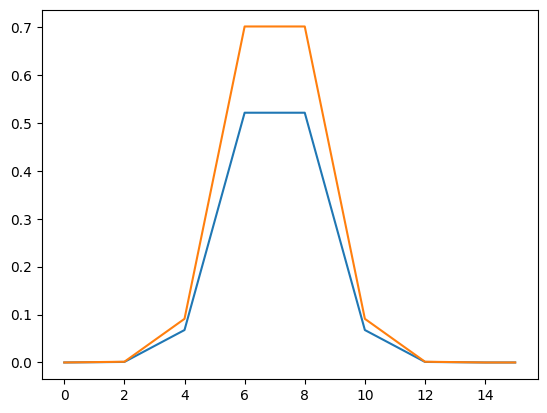

In [7]:
import matplotlib.pyplot as plt
n = 3
qubits_per_dimension = [n]
dims = [2**n for n in qubits_per_dimension]
L = 10
space = Space(qubits_per_dimension, L=[[-L / 2, L / 2]])
r_N = get_position_regular_grid(dims, space.a, space.dx)
sol_N = gaussian(r_N)
sol_N_mps = MPS.from_vector(
    sol_N, [2] * sum(qubits_per_dimension), normalize=False
)
sol_int = interpolate_first_axis(sol_N.reshape(sol_N.shape[0], 1))
sol_int /= np.linalg.norm(sol_int)
sol_int_mps, _ = finite_differences_interpolation_1D(
    sol_N_mps, space, strategy=DEFAULT_STRATEGY.replace(simplify=2)
)
plt.plot(sol_int.flatten())
plt.plot(sol_int_mps.to_vector())

np.allclose(sol_int.flatten(), sol_int_mps.to_vector())

In [46]:
import numpy as np
from seemps.analysis.finite_differences import *
from seemps.analysis.space import Space
from seemps.state import MPS
from seemps.state.core import DEFAULT_STRATEGY, NO_TRUNCATION

from tests.tools import *


def gaussian(x):
    f = np.exp(-(x**2))
    return f / np.linalg.norm(f)


def S_plus_v(n, closed=True):
    S = np.diag(np.ones(2**n - 1), +1)
    if closed:
        S[-1, 0] = 1
    return S


def S_minus_v(n, closed=True):
    S = np.diag(np.ones(2**n - 1), -1)
    if closed:
        S[0, -1] = 1
    return S


def finite_differences_v(n, Δx, closed=True):
    return (1 / Δx**2) * (
        S_plus_v(n, closed=closed) + S_minus_v(n, closed=closed) - 2 * np.eye(2**n)
    )


class TestFiniteDifferences(TestCase):
    def test_finite_differences(self):
        for n in range(2, 10):
            qubits_per_dimension = [n]
            dims = [2**n for n in qubits_per_dimension]
            L = 10
            space = Space(qubits_per_dimension, L=[[-L / 2, L / 2]])
            x = space.x[0]
            Δx = space.dx[0]
            v = gaussian(x)
            fd_sol = finite_differences_v(n, Δx, closed=True) @ v
            ψ = MPS.from_vector(v, [2] * n, normalize=False, strategy=NO_TRUNCATION)
            fd_mps_sol = (
                finite_differences_mpo(n, Δx, closed=True, strategy=NO_TRUNCATION) @ ψ
            )
            self.assertSimilar(fd_sol, fd_mps_sol)

In [47]:
suite1 = unittest.TestLoader().loadTestsFromNames(['__main__.TestFiniteDifferences'])
unittest.TextTestRunner(verbosity=2).run(suite1);

test_finite_differences (__main__.TestFiniteDifferences.test_finite_differences) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.013s

OK


In [40]:
mpoA = MPO([σx.reshape(1, 2, 2, 1)] * 10)
mpoB = MPO([σz.reshape(1, 2, 2, 1)] * 10)
mposum = mpoA + mpoB
state = random_uniform_mps(2, mpoA.size, D=10)
r1 = mposum.apply(state + state)
r2 = simplify(mpoA.apply(2*state)+mpoB.apply(2*state), strategy=DEFAULT_STRATEGY.replace(simplify=Simplification.VARIATIONAL))
r3 = mposum @ (state + state)

In [41]:
print(r1.to_vector())
print(r2.to_vector())
print(r3.to_vector())

[-6056.91128233  4533.28055751   -79.02661144 ...    79.02661144
 -4533.28055751 -6056.91128233]
[-6056.91128233  4533.28055751   -79.02661144 ...    79.02661144
 -4533.28055751 -6056.91128233]
[-6056.91128233  4533.28055751   -79.02661144 ...    79.02661144
 -4533.28055751 -6056.91128233]
